In [3]:
import re # for regular expressions
import pandas as pd 
pd.set_option("display.max_colwidth", 200)
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import string #additional tools to manipulate strings
import warnings 
import spacy

import nltk
from yellowbrick.text.postag import postag
from yellowbrick.text import PosTagVisualizer

from autocorrect import Speller

spell = Speller(lang='en')

warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

plt.rcParams.update(plt.rcParamsDefault)

plt.rcParams['font.family'] = "serif"

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
import en_core_web_sm
nlp = en_core_web_sm.load()

# Merging Module 3 Question Data

In [8]:
%cd /Users/mayanksharma/Desktop/DICE Text Analysis Cohort 2/Module 3
train  = pd.read_csv('howdoesidentitychange.csv',engine='python')
train1 = pd.read_csv('reflections.csv',engine='python')

/Users/mayanksharma/Desktop/DICE Text Analysis Cohort 2/Module 3


In [9]:
frames = [train,train1]

train = pd.concat(frames)
train.shape

(1629, 1)

# Cleaning Data - without Lemmatization, Stop Word Removal and Punctuations

In [10]:
train['tidy_response'] = train['response'].str.replace("Reply", " ")
train['tidy_response'] = train['tidy_response'].str.replace("Show original comment", " ")
count = train['tidy_response'].str.split().str.len()
train=train[~(count==1)]
train['tidy_response'] = train['tidy_response'].str.replace("�", " ")
train['tidy_response']=train['tidy_response'].str.lower()
train=train[~train.tidy_response.str.contains("2019")]
train=train.drop("response",axis=1)

train.reset_index(drop=True, inplace=True)
nan_value = float("NaN")
train.replace(" ", nan_value, inplace=True)
train.dropna(subset = ["tidy_response"], inplace=True)
train.reset_index(drop=True, inplace=True)

train=train.drop_duplicates(subset=['tidy_response'], keep=False)
train.reset_index(drop=True, inplace=True)
train.shape


(335, 1)

# Spell Check

In [11]:
for i in range(0,len(train)):

    train['tidy_response'][i]=spell(train['tidy_response'][i])
    

# POS Tagging and Count Plotting

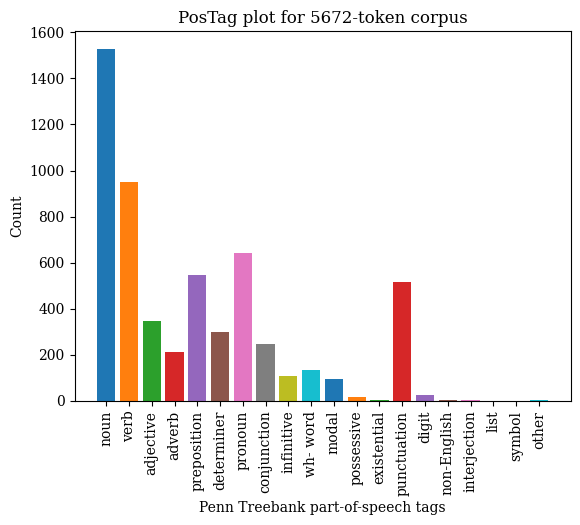

<AxesSubplot:title={'center':'PosTag plot for 5672-token corpus'}, xlabel='Penn Treebank part-of-speech tags', ylabel='Count'>

In [12]:
list1=[]

for i in range(0,len(train)):
    
    tokens = nltk.word_tokenize(train['tidy_response'][i].lower())
    text = nltk.Text(tokens)
    tags = nltk.pos_tag(text)
    list1.append(tags)
    
list2=[list1]
viz = PosTagVisualizer()
viz.fit(list2)
viz.show()

# Removal of Punctuations

In [13]:
train['tidy_response'] = train['tidy_response'].str.replace("[\.\,\!\?\:\;\-\=*$%^&(){}~<>€|\"]", " ")
train['tidy_response'] = train['tidy_response'].str.replace("\\", " ")
train.reset_index(drop=True, inplace=True)
nan_value = float("NaN")
train.replace(" ", nan_value, inplace=True)
train.dropna(subset = ["tidy_response"], inplace=True)
train.reset_index(drop=True, inplace=True)

train=train.drop_duplicates(subset=['tidy_response'], keep=False)
train.head()
train.reset_index(drop=True, inplace=True)
train.shape



(333, 1)

In [14]:
train.shape

(333, 1)

# Point of View

In [15]:
import pointofview as pov

out = []

for i in range(0,len(train)):
    a=pov.get_text_pov(train['tidy_response'][i])
    out += [a]


In [16]:
out.count('first')

159

In [17]:
out.count('second')

31

In [18]:
out.count('third')

34

# Lemmatization

In [19]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

train['tidy_response'] = train.tidy_response.apply(lemmatize_text)
train['tidy_response']=train['tidy_response'].apply(lambda row: " ".join([w for w in row]))
train.head()

,tidy_response
0,im good but i want to be the best
1,im small but smart
2,im a student but i wanna be a famous actor in the future
3,a our go forward our identity is changing
4,i think identity is changing by course of time


In [20]:
train.shape

(333, 1)

# Dependency Parsing

In [21]:
from spacy import displacy 
displacy.render(nlp(train['tidy_response'][1]), style='dep',jupyter=True)

In [22]:
from pathlib import Path
from spacy import displacy 

svg=displacy.render(nlp("we migrate because of natural disasters"), style='dep',jupyter=False) 
file_name = "dp.svg"
output_path = Path("/Users/mayanksharma/Desktop/DICE Text Analysis/Module 1" + file_name)
output_path.open("w", encoding="utf-8").write(svg)
    

4694

# Shallow Parsing

Adjective Noun Structure

In [23]:
#Adjective Noun Structure

def rule2(text):
    
    doc = nlp(text)

    pat = []
    
    # iterate over tokens
    for token in doc:
        phrase = ''
        # if the word is a subject noun or an object noun
        if (token.pos_ == 'NOUN')\
            and (token.dep_ in ['dobj','pobj','nsubj','nsubjpass']):
            
            # iterate over the children nodes
            for subtoken in token.children:
                # if word is an adjective or has a compound dependency
                if (subtoken.pos_ == 'ADJ') or (subtoken.dep_ == 'compound'):
                    phrase += subtoken.text + ' '
                    
            if len(phrase)!=0:
                phrase += token.text
             
        if  len(phrase)!=0:
            pat.append(phrase)
        
    
    return pat

In [24]:
#Verb Adjective/Noun Structure

def rule3(text):
    
    doc = nlp(text)

    pat = []
    
    # iterate over tokens
    for token in doc:
        phrase = ''
        # if the word is a subject noun or an object noun
        if (token.pos_ == 'VERB'):
            
            # iterate over the children nodes
            for subtoken in token.children:
                # if word is an adjective or has a compound dependency
                if (subtoken.pos_ == 'ADJ') or (subtoken.dep_ == 'acomp'):
                    phrase += subtoken.text + ' '
                    
            if len(phrase)!=0:
                phrase += token.text
             
        if  len(phrase)!=0:
            pat.append(phrase)
        
    
    return pat

In [25]:
output = pd.DataFrame()
for i in range(0,len(train)):
    a=rule2(train['tidy_response'][i])
    output=output.append(a, ignore_index=True)
output.columns=['re']
output.head()

,re
0,different identity
1,many feeling
2,school student
3,many experience
4,own idea


In [26]:
output.shape

(151, 1)

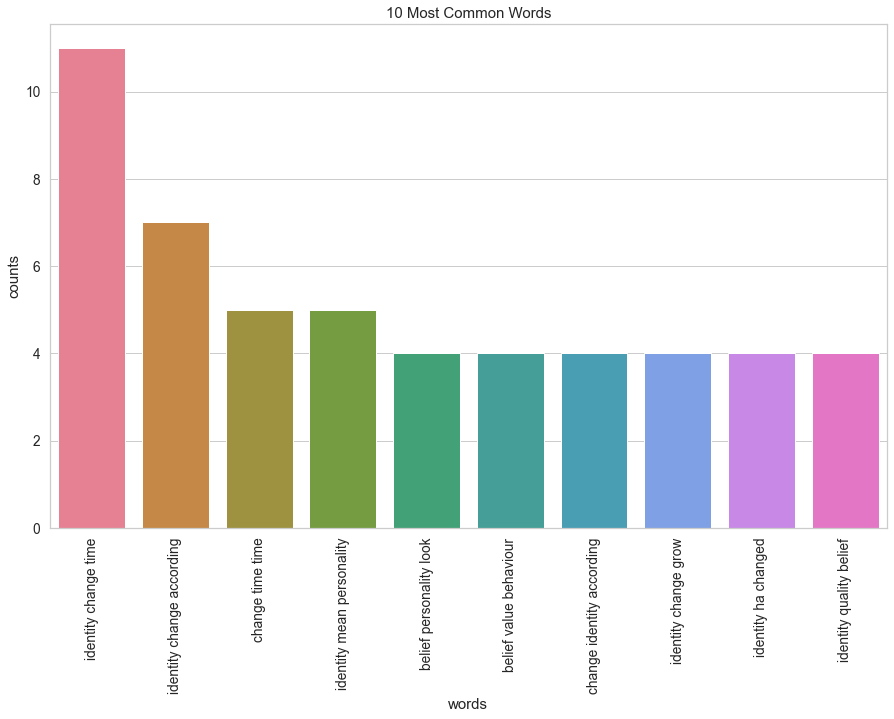

<Figure size 432x288 with 0 Axes>

In [33]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
plt.rcParams['font.family'] = "serif"
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 Most Common Words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english',ngram_range=(3,3))
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(train['tidy_response'])
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)
plt.savefig('filename.png', dpi=300, bbox_inches = 'tight')

In [27]:
a=rule3(train['tidy_response'][0])
type(a)

list

In [28]:
a

['comfortable feel']

In [29]:
a=nltk.word_tokenize(a[0])
a

['comfortable', 'feel']

In [30]:
a.reverse()

a

['feel', 'comfortable']

In [31]:
a=' '.join(a)
a

'feel comfortable'

In [32]:
a=[a]
a

['feel comfortable']

In [28]:
output1 = pd.DataFrame()
for i in range(0,len(train)):
    a=rule3(train['tidy_response'][i])
    output1=output1.append(a, ignore_index=True)
output1.columns=['re']
output1.head()

,re
0,good m
1,small m
2,little changing
3,other recognize
4,nose wa


In [29]:
output1.shape

(34, 1)

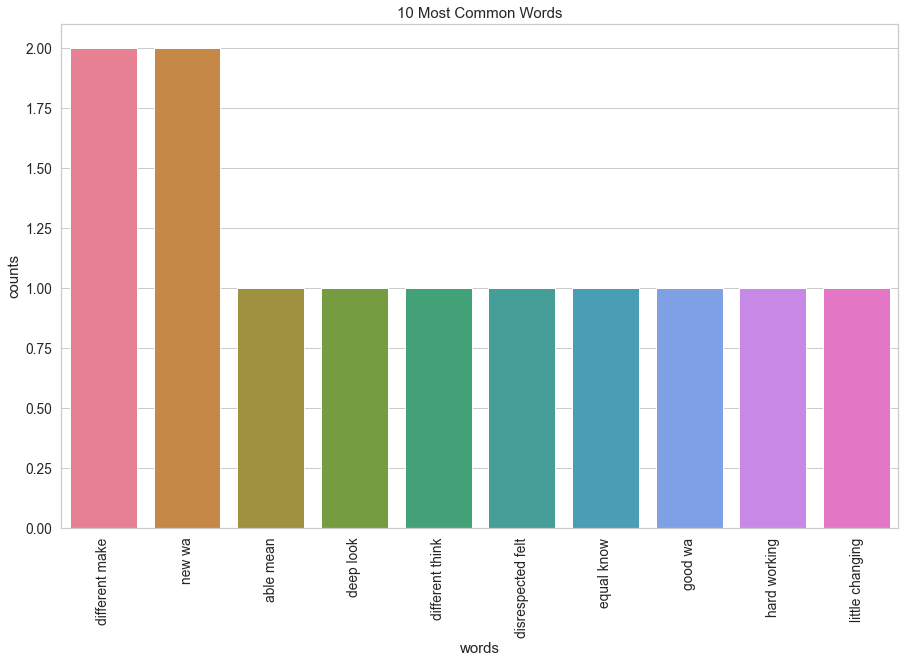

<Figure size 432x288 with 0 Axes>

In [30]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
plt.rcParams['font.family'] = "serif"
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 Most Common Words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english',ngram_range=(2,2))
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(output1['re'])
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)
plt.savefig('filename.png', dpi=300, bbox_inches = 'tight')



# TF-IDF Vectorization and K-Means Clustering

In [34]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.1,max_features=200000, stop_words='english',
                                 use_idf=True, ngram_range=(1,2))

X = tfidf_vectorizer.fit_transform(output['re']) #fit the vectorizer to synopses

print(X.shape)

(151, 241)


In [35]:
terms = tfidf_vectorizer.get_feature_names()

In [36]:
number_of_clusters = 5

model = KMeans(n_clusters=number_of_clusters, 
               init='k-means++', 
               max_iter=100, # Maximum number of iterations of the k-means algorithm for a single run.
               n_init=1)  # Number of time the k-means algorithm will be run with different centroid seeds. The final results will be the best output of n_init consecutive runs in terms of inertia.

model.fit(X)

KMeans(max_iter=100, n_clusters=5, n_init=1)

In [37]:
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names()

In [38]:
for i in range(number_of_clusters):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :5]:
        print(' %s' % terms[ind])

Cluster 0:
 different
 good
 view identity
 view
 behavior
Cluster 1:
 identity change
 change
 year
 feeling
 greater
Cluster 2:
 professional identity
 professional
 year
 family
 good identity
Cluster 3:
 idea
 value
 self
 belief
 experience
Cluster 4:
 personal
 personal opinion
 opinion
 year
 family
